In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
# Cargar datos
df = pd.read_csv('./datos/dataset_limpio_s_outliers.csv', parse_dates=['fecha'])
df.head()

,fecha,marca,ea,er,eo,gfa,gfr,abv,pH,grupo,...,reposo4_temp,pH_1,primer_mosto_extracto,ultima_agua_extracto,agua_lavado_temp,temperatura_llenado,paila_llena_extracto,ebullicion_minutos,ebullicion_temp,mosto_frio_extracto
0,7/06/2023,IPA,2.67,5.11,15.39,82.651072,66.796621,6.91,4.31,"803,804,805,806,807,808",...,72.233333,5.605,18.381667,1.516667,76.166667,74.300000,14.988333,50.0,100.966667,15.993333
1,7/06/2023,IPA,2.67,5.10,15.35,82.605863,66.775244,6.88,4.31,"829,830,831",...,72.233333,5.610,18.466667,1.496667,76.166667,74.400000,15.083333,50.0,100.866667,16.043333
2,7/06/2023,IPA,2.67,5.11,15.41,82.673589,66.839714,6.92,4.31,"803,804,805,806,807,808",...,72.233333,5.605,18.381667,1.516667,76.166667,74.300000,14.988333,50.0,100.966667,15.993333
3,8/06/2023,IPA,2.62,5.09,15.54,83.140283,67.245817,7.03,4.38,"794,816,817",...,72.250000,5.585,18.875000,1.535000,76.600000,74.750000,14.990000,50.0,101.000000,16.000000
4,10/06/2023,IPA,2.67,5.06,15.17,82.399473,66.644693,6.78,4.48,"826,827,828",...,72.166667,5.600,18.390000,1.533333,76.200000,74.133333,15.000000,50.0,100.933333,16.000000


In [3]:
# IMPLEMENTACION DE REGRESION LINEAL CON VALIDACION CRUZADA K-FOLD DE DATOS SIN PCA

vars_maceracion_mosto = [
    'reposo2_min', 'reposo2_temp',
    'reposo3_min', 'reposo3_temp',
    'reposo4_min', 'reposo4_temp',
    'pH_1',
    'primer_mosto_extracto', 'ultima_agua_extracto',
    'agua_lavado_temp', 'temperatura_llenado',
    'paila_llena_extracto', 'ebullicion_minutos',
    'ebullicion_temp', 'mosto_frio_extracto'
]

df_model_outpca = df[vars_maceracion_mosto + ['abv']].copy()
X = df_model_outpca.drop(columns='abv')
y = df_model_outpca['abv']

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Modelo base: Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicción y evaluación en test
y_pred = lr.predict(X_test)
y_pred_lr = lr.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

# Validación cruzada (k=5)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse = cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_cv = cross_val_score(lr, X, y, cv=cv, scoring='r2')
rmse_cv = np.sqrt(-neg_mse)
print(f"CV RMSE (media ± std): {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"CV R² (media ± std): {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

Test RMSE: 0.139
Test R²: 0.110
CV RMSE (media ± std): 0.122 ± 0.015
CV R² (media ± std): 0.239 ± 0.099


In [4]:
# IMPLEMENTACION DE REGRESION PLS CON BUSQUEDA DE COMPONENTES OPTIMOS Y VALIDACION CRUZADA K-FOLD
vars_maceracion_mosto = [
    'reposo2_min', 'reposo2_temp',
    'reposo3_min', 'reposo3_temp',
    'reposo4_min', 'reposo4_temp',
    'pH_1',
    'primer_mosto_extracto', 'ultima_agua_extracto',
    'agua_lavado_temp', 'temperatura_llenado',
    'paila_llena_extracto', 'ebullicion_minutos',
    'ebullicion_temp', 'mosto_frio_extracto'
]

df_model_outpca = df[vars_maceracion_mosto + ['abv']].copy()

# Definir X e y
X = df_model_outpca.drop(columns='abv')
y = df_model_outpca['abv']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Escalado de X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selección del número óptimo de componentes PLS por CV
n_comps = list(range(1, X_train_scaled.shape[1]+1))
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse_cv = []

for n in n_comps:
    pls = PLSRegression(n_components=n)
    neg_mse = cross_val_score(pls, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')
    mse_cv.append(-neg_mse.mean())

optimal_n = n_comps[int(np.argmin(mse_cv))]
print(f"Componentes óptimos (CV): {optimal_n}")

# Entrenar PLS con número óptimo de componentes
pls_opt = PLSRegression(n_components=optimal_n)
pls_opt.fit(X_train_scaled, y_train)

# Evaluación en test
y_pred = pls_opt.predict(X_test_scaled)
y_pred_pls = pls_opt.predict(X_test_scaled).ravel()
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE (PLS): {rmse_test:.3f}")
print(f"Test R² (PLS): {r2_test:.3f}")

# Validación cruzada final sobre todo X
pls_final = PLSRegression(n_components=optimal_n)
neg_mse_full = cross_val_score(pls_final, scaler.fit_transform(X), y, cv=cv, scoring='neg_mean_squared_error')
r2_full = cross_val_score(pls_final, scaler.transform(X), y, cv=cv, scoring='r2')
rmse_full = np.sqrt(-neg_mse_full)
print(f"CV RMSE (PLS): {rmse_full.mean():.3f} ± {rmse_full.std():.3f}")
print(f"CV R² (PLS): {r2_full.mean():.3f} ± {r2_full.std():.3f}")

Componentes óptimos (CV): 5
Test RMSE (PLS): 0.138
Test R² (PLS): 0.126
CV RMSE (PLS): 0.121 ± 0.014
CV R² (PLS): 0.242 ± 0.098


In [5]:
#SELECCION DE COMPONENTES OPTIMOS EN PLS MEDIANTE VALIDACION CRUZADA Y EVALUACION EN TEST

vars_maceracion_mosto = [
    'reposo2_min', 'reposo2_temp',
    'reposo3_min', 'reposo3_temp',
    'reposo4_min', 'reposo4_temp',
    'pH_1',
    'primer_mosto_extracto', 'ultima_agua_extracto',
    'agua_lavado_temp', 'temperatura_llenado',
    'paila_llena_extracto', 'ebullicion_minutos',
    'ebullicion_temp', 'mosto_frio_extracto'
]

df_model_outpca = df[vars_maceracion_mosto + ['abv']].copy()

# Definir X e y usando df_model ya existente
X = df_model_outpca.drop(columns='abv')
y = df_model_outpca['abv']

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selección de n_components entre 1 y 8 mediante CV (5 folds)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
n_comps = range(1, 9)
mse_cv = []

for n in n_comps:
    pls = PLSRegression(n_components=n)
    neg_mse = cross_val_score(pls, X_train_scaled, y_train, cv=cv,
                              scoring='neg_mean_squared_error')
    mse_cv.append(-neg_mse.mean())

# Mostrar resultados CV para cada n_components
for n, mse in zip(n_comps, mse_cv):
    print(f"n_components={n}, CV RMSE={np.sqrt(mse):.3f}")

# Definir número óptimo de componentes
optimal_n = n_comps[np.argmin(mse_cv)]
print(f"\nComponente óptimo (mínimo CV RMSE): {optimal_n}")

# Entrenar PLS con n_components=optimal_n y evaluar en test
pls_opt = PLSRegression(n_components=optimal_n)
pls_opt.fit(X_train_scaled, y_train)
y_pred = pls_opt.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"\nTest RMSE (PLS n={optimal_n}): {rmse_test:.3f}")
print(f"Test R² (PLS n={optimal_n}): {r2_test:.3f}")


n_components=1, CV RMSE=0.119
n_components=2, CV RMSE=0.116
n_components=3, CV RMSE=0.115
n_components=4, CV RMSE=0.115
n_components=5, CV RMSE=0.115
n_components=6, CV RMSE=0.115
n_components=7, CV RMSE=0.115
n_components=8, CV RMSE=0.115

Componente óptimo (mínimo CV RMSE): 5

Test RMSE (PLS n=5): 0.138
Test R² (PLS n=5): 0.126


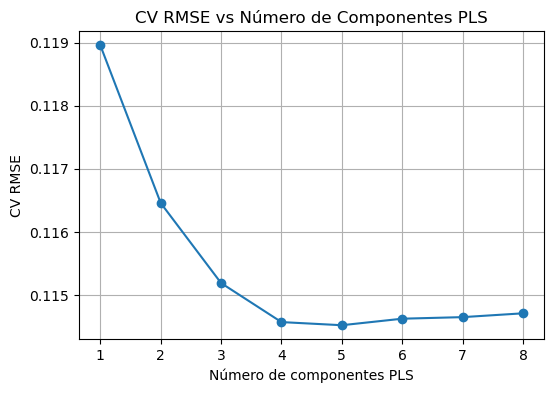

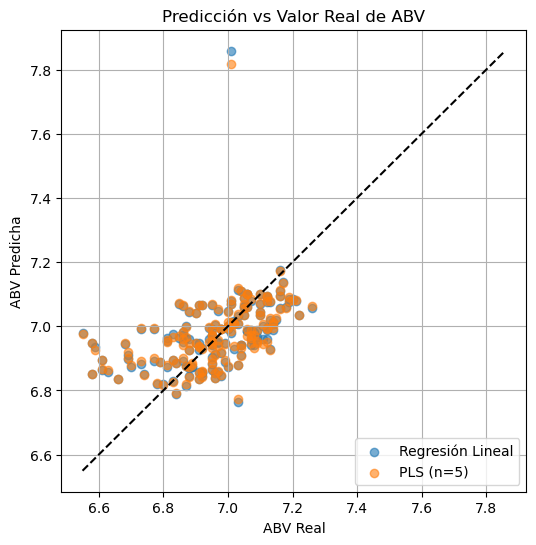

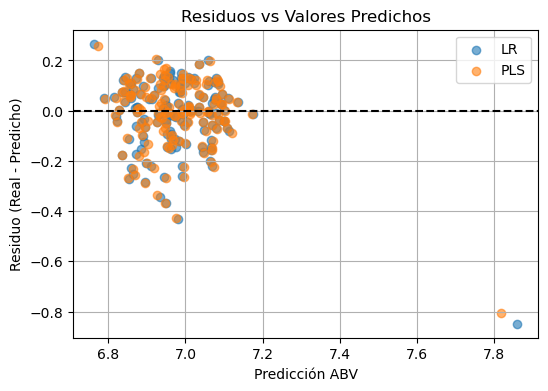

In [6]:
# EVALUACION GRAFICA DE MODELOS: CURVA CV RMSE PLS, PREDICCION VS REAL Y ANALISIS DE RESIDUOS

# Curva CV RMSE vs número de componentes (PLS)
plt.figure(figsize=(6,4))
plt.plot(list(n_comps), np.sqrt(mse_cv), marker='o')
plt.xlabel('Número de componentes PLS')
plt.ylabel('CV RMSE')
plt.title('CV RMSE vs Número de Componentes PLS')
plt.grid(True)
plt.show()

# Scatter Predicción vs Real (ABV) para ambos modelos

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Regresión Lineal')
plt.scatter(y_test, y_pred_pls, alpha=0.6, label=f'PLS (n={optimal_n})')
mn, mx = min(y_test.min(), y_pred_lr.min(), y_pred_pls.min()), max(y_test.max(), y_pred_lr.max(), y_pred_pls.max())
plt.plot([mn, mx], [mn, mx], 'k--')
plt.xlabel('ABV Real')
plt.ylabel('ABV Predicha')
plt.title('Predicción vs Valor Real de ABV')
plt.legend()
plt.grid(True)
plt.show()

# Residuals vs Predichos
resid_lr = y_test - y_pred_lr
resid_pls = y_test - y_pred_pls

plt.figure(figsize=(6,4))
plt.scatter(y_pred_lr, resid_lr, alpha=0.6, label='LR')
plt.scatter(y_pred_pls, resid_pls, alpha=0.6, label='PLS')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Predicción ABV')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Residuos vs Valores Predichos')
plt.legend()
plt.grid(True)
plt.show()
